<a href="https://colab.research.google.com/github/leesurkis/Sentinel/blob/master/DisinformationClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Clustering Disinformation**

To clustering items, we use unsupervised learning techniques, this is a common use for grouping text documents where we don't have labels for each document. The model will group similar documents together in clusters which can then be labelled by a human. 

1. EDA

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv, re
import nltk
import string
from html.parser import HTMLParser
import pickle
import logging
import numpy as np

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS , ImageColorGenerator
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from gensim import corpora, models, similarities, matutils

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# import data
data = pd.read_json('/clusters.json')
data.head()

,id,text,title,lang,date,cluster,cluster_name
0,https://www.fondsk.ru/news/2020/03/24/litva-ne...,The coronavirus epidemic in Lithuania has clea...,"Lithuania: No Physicians, No Food Stock - Stra...",eng,2020-03-24 00:00:00,0,MS fails to respond
1,https://www.rubaltic.ru/article/politika-i-obs...,European experts say that the countries of Eas...,Coronavirus caused a catastrophe in the Baltic,eng,2020-03-19 08:50:37,0,MS fails to respond
2,http://pandemya.ru/shveciya-otkazalas-ot-borby...,Sweden refused to fight against coronavirus: “...,Sweden abandoned the fight against coronavirus...,eng,None,0,MS fails to respond
3,https://southfront.org/coronavirus-hysteria-hi...,"Donate\nDuring the past week, the center of th...",Coronavirus Hysteria Hits Russia As Europe Bec...,eng,2020-03-14 12:27:02,0,MS fails to respond
4,https://www.fondsk.ru/news/2020/03/24/shvedski...,The Swedish oligarchs in conjunction with the ...,Swedish capital slows down in an epidemic and ...,eng,2020-03-24 00:00:00,0,MS fails to respond


In [ ]:
# initial checks 

# data types 
print(data.dtypes) # may need to convert 

# shape
print(data.shape)

# nulls 
data.isnull().sum()

id              object
text            object
title           object
lang            object
date            object
cluster          int64
cluster_name    object
dtype: object
(181, 7)


id              0
text            0
title           0
lang            0
date            0
cluster         0
cluster_name    0
dtype: int64

In [ ]:
# the dataset has been pre-labelled, view the different types of clusters in the dataset
unique_clusters = data.drop_duplicates('cluster_name')
unique_clusters

,id,text,title,lang,date,cluster,cluster_name
0,https://www.fondsk.ru/news/2020/03/24/litva-ne...,The coronavirus epidemic in Lithuania has clea...,"Lithuania: No Physicians, No Food Stock - Stra...",eng,2020-03-24 00:00:00,0,MS fails to respond
9,https://es.news-front.info/2020/02/23/el-coron...,"After years of repeating the mantra of ""Russia...",Coronavirus is the New Black Spot: Another Pag...,eng,2020-02-23 00:00:00,1,Anti-Russia
17,https://mundo.sputniknews.com/asia/20200204109...,"Since January 31, the same topic has been spok...","The coronavirus, a weapon that has fallen from...",eng,None,2,Claims about China
39,https://www.geopolitica.ru/it/article/lordine-...,THE POST-GLOBAL ORDER IS SOMETHING INEVITABLE\...,THE POST-GLOBAL ORDER IS SOMETHING INEVITABLE,eng,2020-03-19 19:50:48,3,Collapse
47,https://southfront.org/the-coronavirus-covid-1...,Donate\nWritten by Peter Koenig; Originally ap...,The Coronavirus COVID-19 Pandemic: The Real Da...,eng,2020-03-13 08:18:52,4,Coronavirus is not serious
58,https://antikor.com.ua/articles/365314-u_vas_e...,"According to the suggested advice, your body c...","""You have 4 days"": a new method for the preven...",eng,None,5,Cure
64,https://southfront.org/european-unity-poland-r...,Donate\nSince the start of the COVID-19 crisis...,‘European Unity’: Poland Reportedly Closed Air...,eng,2020-03-24 11:38:21,6,EU fails to respond
84,https://www.geopolitica.ru/article/ssha-pricha...,USA involved in the spread of coronavirus\nThe...,USA involved in the spread of coronavirus,eng,2020-03-17 19:36:26,7,Miscellaneous
104,https://menafn.com/arabic/1099899779/%D8%B1%D9...,(MENAFN - Youm7) The head of Russia's medical ...,Russia announces the end of the first phase of...,eng,None,8,Origins
112,https://www.kp.ru/daily/27084/4156051/,Coronavirus outbreak: China could be hit with ...,Coronavirus outbreak: China could be hit with ...,eng,2020-01-28 13:38:00,9,Properties


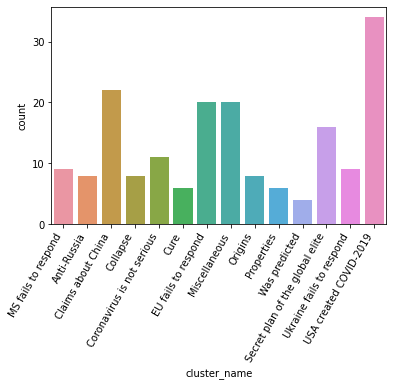

In [ ]:
# view distribution of each cluster

ax = sns.countplot(x='cluster_name', data=data)
sns.set(rc={'figure.figsize':(35,15)})
sns.set(font_scale=2)

xticks = ax.get_xticks()
plt.xticks(rotation="60", ha='right');

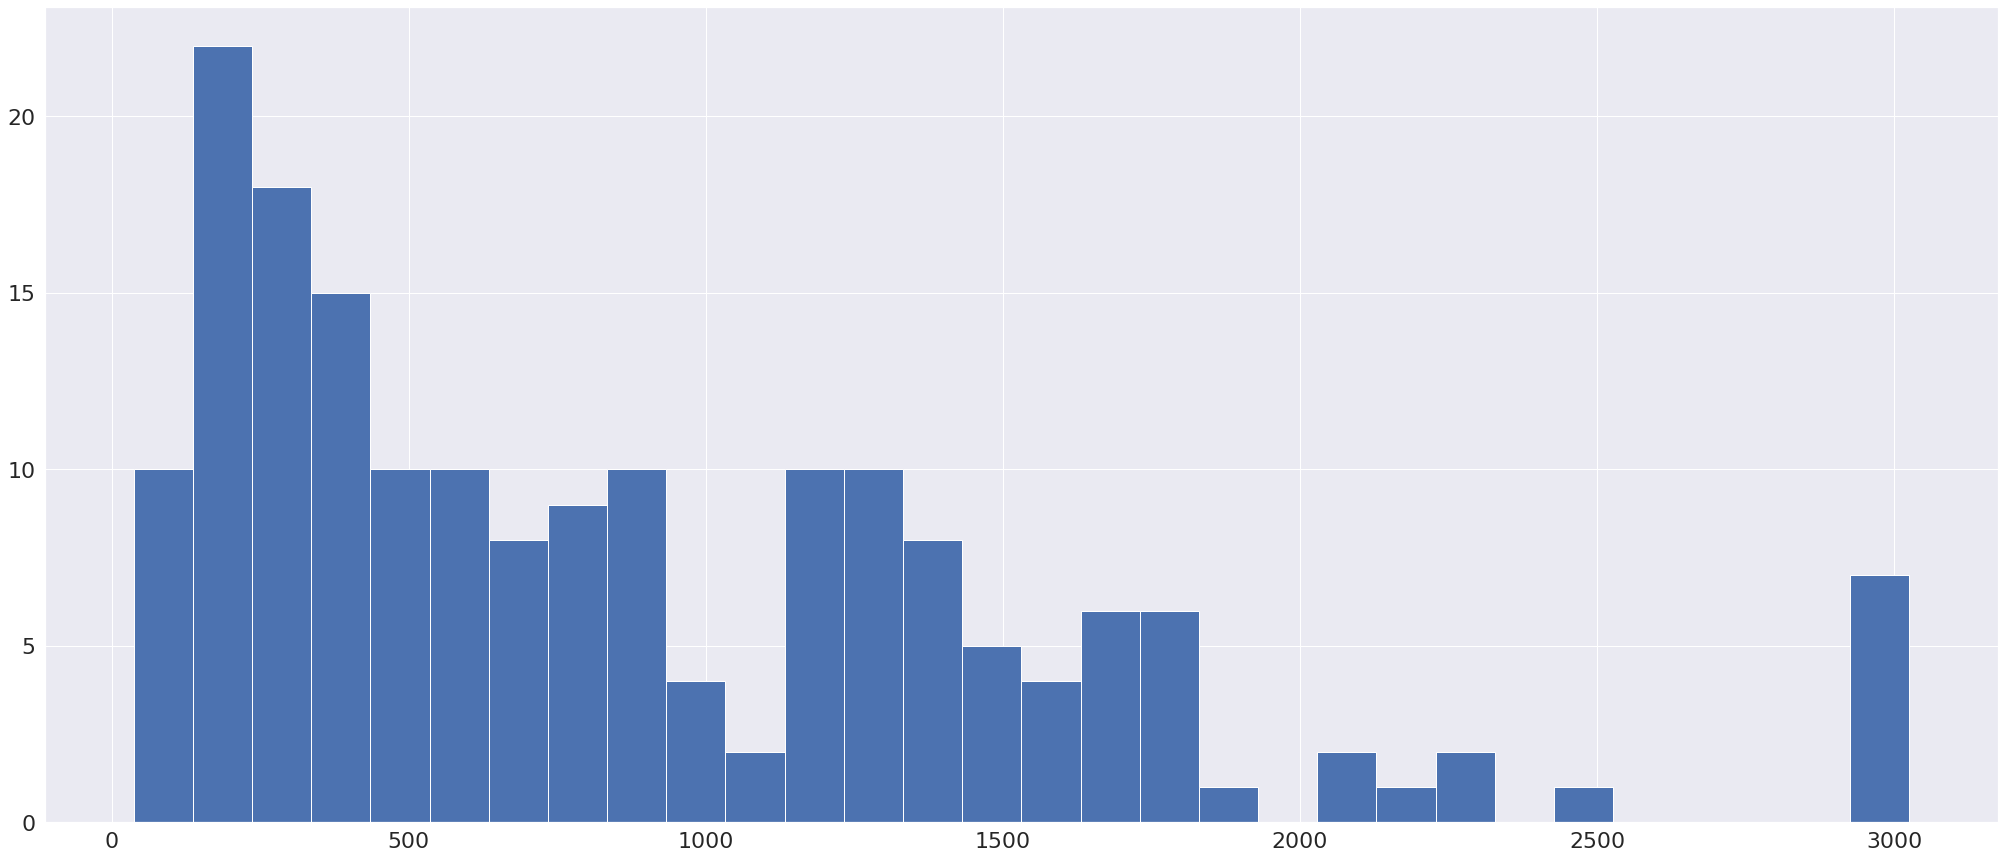

In [ ]:
# create new column for word count
data['words_count'] = data['text'].str.split().str.len()

# check distribution of word count
data.words_count.hist(bins=30);


In [ ]:
# check number of different languages
print(data.lang.unique()) # only 'eng'

# we can drop this col
data.drop(columns=['lang'], inplace=True)

# check shape
print(data.shape)

['eng']
(181, 7)


Initial Observations:
* Dataset is small (181) so it might be difficult to get precise fine grained clusters
* The dataset is pre-labelled, we will remove these in order to see what clusters the model will discover

In [ ]:
# some of the observations have the title repeated in the 'text' col
# code below removes title from text 
data['text_no_title'] = data.text.replace(data.title[data.title.notnull()], '', regex = True).str.strip()
data.head()

,id,text,title,date,cluster,cluster_name,words_count,text_no_title
0,https://www.fondsk.ru/news/2020/03/24/litva-ne...,The coronavirus epidemic in Lithuania has clea...,"Lithuania: No Physicians, No Food Stock - Stra...",2020-03-24 00:00:00,0,MS fails to respond,558,The coronavirus epidemic in Lithuania has clea...
1,https://www.rubaltic.ru/article/politika-i-obs...,European experts say that the countries of Eas...,Coronavirus caused a catastrophe in the Baltic,2020-03-19 08:50:37,0,MS fails to respond,1159,European experts say that the countries of Eas...
2,http://pandemya.ru/shveciya-otkazalas-ot-borby...,Sweden refused to fight against coronavirus: “...,Sweden abandoned the fight against coronavirus...,None,0,MS fails to respond,354,Sweden refused to fight against coronavirus: “...
3,https://southfront.org/coronavirus-hysteria-hi...,"Donate\nDuring the past week, the center of th...",Coronavirus Hysteria Hits Russia As Europe Bec...,2020-03-14 12:27:02,0,MS fails to respond,506,"Donate\nDuring the past week, the center of th..."
4,https://www.fondsk.ru/news/2020/03/24/shvedski...,The Swedish oligarchs in conjunction with the ...,Swedish capital slows down in an epidemic and ...,2020-03-24 00:00:00,0,MS fails to respond,424,The Swedish oligarchs in conjunction with the ...


2. Text Preprocessing

In [ ]:
# copy dataset
data_preprocess = data.copy()

In [ ]:
# text preprocessing 

# remove punctuation
data_preprocess['text'] = data['text'].map(lambda x: re.sub('[^\w]', ' ', x))

# convert to lower care
data_preprocess['text'] = data_preprocess['text'].map(lambda x: x.lower())

# adding words to stop words list
additional_stop_words = ['in', 'the', 'which', 'and', 'there', 'this', 'have'] 
stoplist = text.ENGLISH_STOP_WORDS.union(additional_stop_words)
# removing stop words from text 
data_preprocess['text'].apply(lambda x: [item for item in x if item not in stoplist])

# looking at the data, there were some words with numbers which will interfere with results
# we can remove numbers from words (this will affect mentions of Covid-19 but leave it with just 'covid')
data_preprocess['text'] = data_preprocess['text'].str.replace('\d+', '')

# update word count
data_preprocess['words_count'] = data_preprocess['text'].apply(lambda x: len(x))

# pickel preprocessed df
data_preprocess.to_pickle('data_preprocessed.pkl')

# drop cols we don't need to keep text only
text_data = data_preprocess[['text']]

print(text_data.shape)
text_data.head()


(181, 1)


,text
0,the coronavirus epidemic in lithuania has clea...
1,european experts say that the countries of eas...
2,sweden refused to fight against coronavirus ...
3,donate during the past week the center of the...
4,the swedish oligarchs in conjunction with the ...


With more time, I would remove of group all mentions of Coronavirus. As we want 'fine grained' clusters, but all the articles are talking about the same main topic, it would make sense to remove mention of the bigger topic in order to focus on the more detailed sub-topics.

In [ ]:
# checking example of before and after pre-processing
print(' '.join(text_data.iloc[0]))
print()
print(data.text.iloc[0].replace('\r', '').replace('\n', ''))

# removal of punctuation has left us with one-letter words, remove every word with 2 letters or less
text_data['text'] = text_data['text'].str.replace(r'\b(\w{1,2})\b', '')

# checking example of before and after pre-processing
print(' '.join(text_data.iloc[0]))
print()
print(data.text.iloc[0].replace('\r', '').replace('\n', ''))

the coronavirus epidemic in lithuania has clearly demonstrated the results of democratic reforms on the way to a  bright european future   at the very beginning of the ххl century  the optimization of medicine and health care was carried out in lithuania  as a result of which the number of medical institutions was sharply reduced   all small ones were closed and only large ones were left  today in the country there are only five medical centers in the largest cities   in kaunas  klaipeda  siauliai  panevezys and vilnius  in the districts  something like paramedic points remained for emergency assistance  if there are few hospitals  then there are few doctors   and today this problem is one of the main ones  we have to involve senior students of medical universities in the fight against the epidemic  but all the same  specialists are sorely lacking  the minister of defense of lithuania raimundas karoblis has already promised that the military will be sent to help the doctors  but would 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


3. Vectorising


Vectorizers map words to numbers to find word similarities. We need the text in vector form as an input for the model. I will try a few different methods. 

In [ ]:
# count vectorize 
cv = CountVectorizer(stop_words='english')

X = cv.fit_transform(text_data.text)
count_vecs = pd.DataFrame(X.toarray(), index=text_data.text, columns=cv.get_feature_names())

# print shape
count_vecs.shape

(181, 10385)

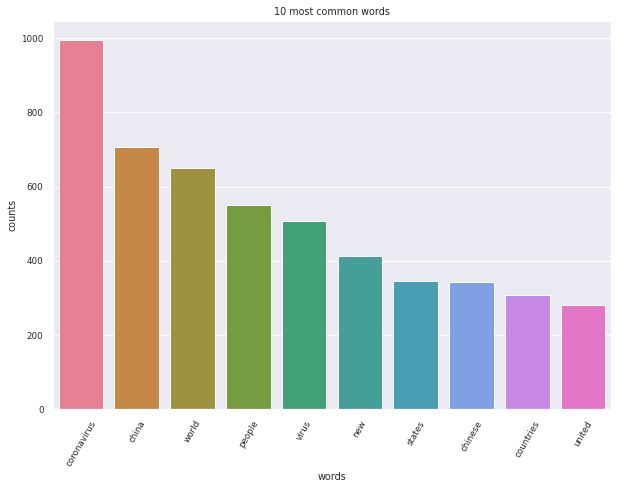

In [ ]:
# visialise common words from count vectorizing 
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(10, 10/1.4))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=0.8, rc={"lines.linewidth": 2})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=60) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

plot_10_most_common_words(X, cv)

In [ ]:
# tf-idf vectorizer
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    ngram_range=(1, 1),
    max_features=10000)

X = word_vectorizer.fit_transform(text_data.text)

In [ ]:

tfidf_vecs  = pd.DataFrame(X.toarray(), index=text_data.text, columns=word_vectorizer.get_feature_names())

In [ ]:
tfidf_vecs.shape

(181, 10000)

4. Modelling 

I will explore using different models in order to determine topics. The models work in slightly different ways to perform dimensionality reduction. We are compressing each article to remove noise and see only the most important key words (which will be grouped into topics).

First model - LSA (Latest Semantic Analysis)

In [ ]:
# LSA on my Count Vectorized data 
lsa = TruncatedSVD(4)
doc_topic = lsa.fit_transform(count_vecs)

# look at explained variance to measure performance
lsa.explained_variance_ratio_

array([0.16608189, 0.0767394 , 0.05533661, 0.03913298])

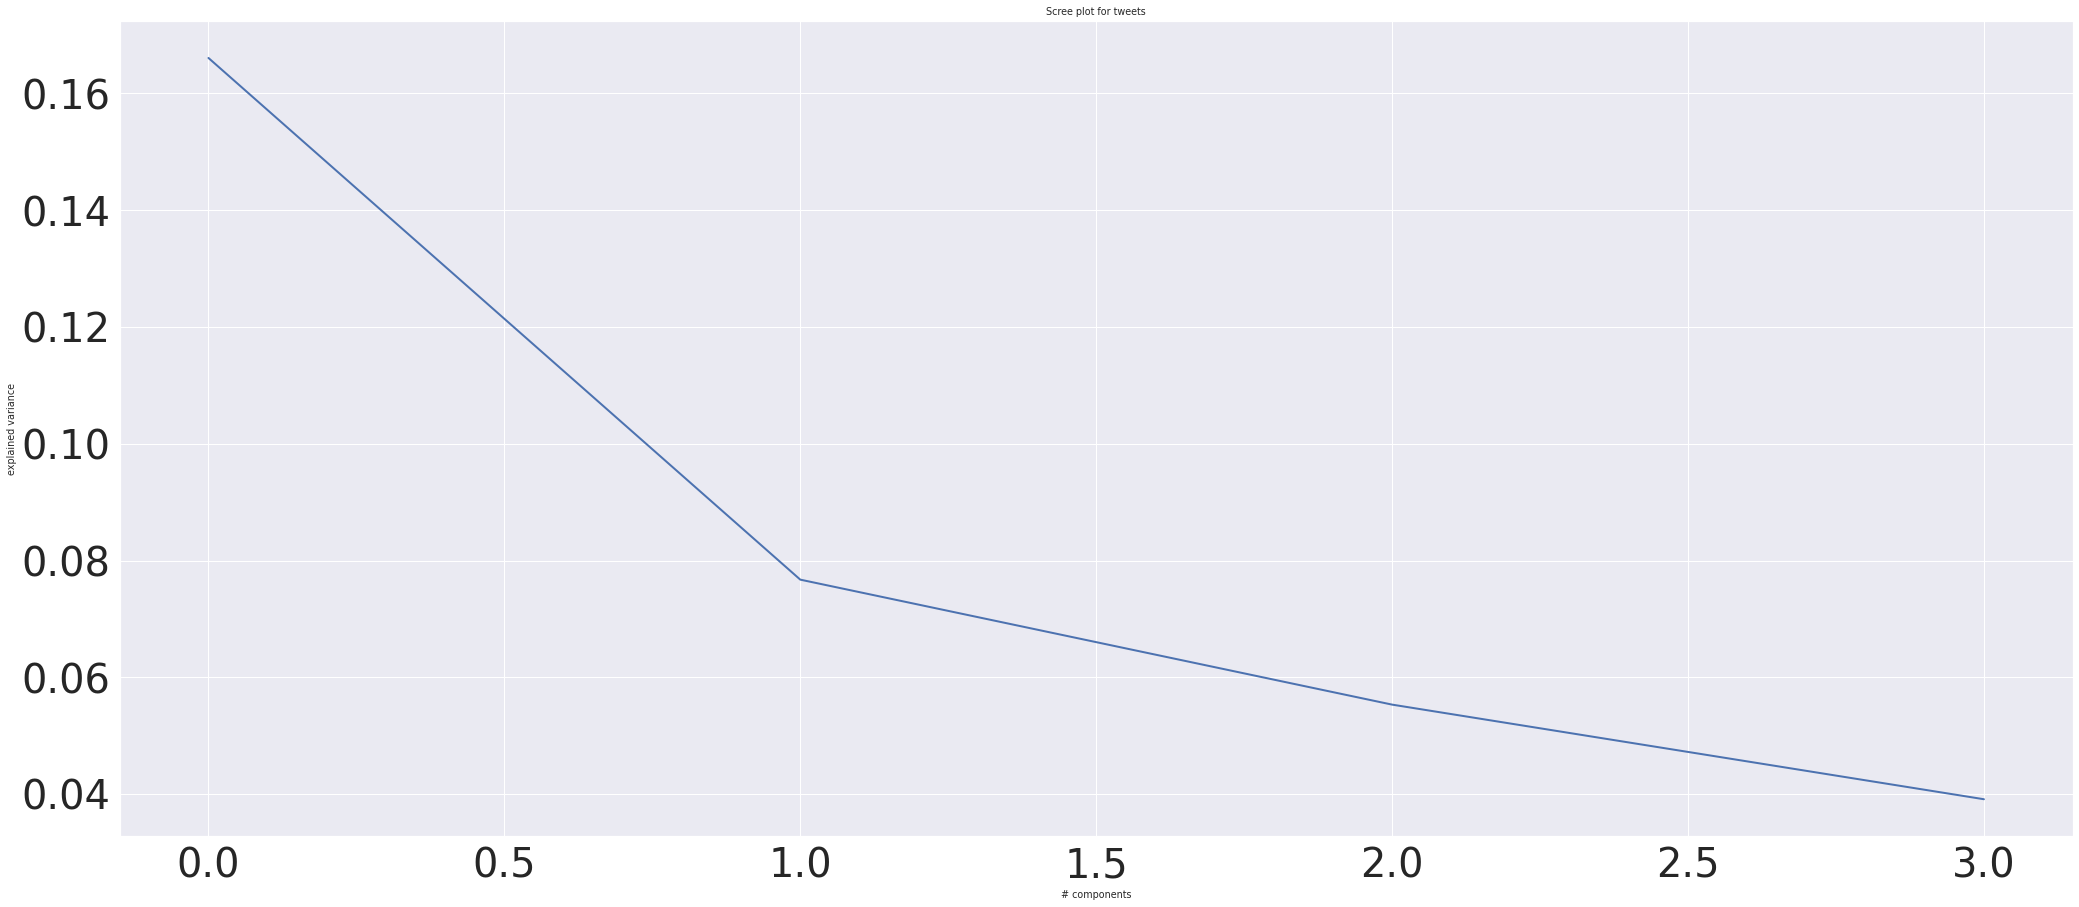

In [ ]:
# we can plot the explained variance to see the optimum number of topics 
plt.plot(lsa.explained_variance_ratio_)
plt.xlabel('# components')
plt.ylabel('explained variance')
plt.title('Scree plot')
plt.tick_params(labelsize=40);

In [ ]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2","component_3", "component_4"],
             columns = cv.get_feature_names())
topic_word

,_dokumente,_materialien,abandon,abandoned,abandoning,abc,abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyz,abdin,abe,abide,ability,able,abnormally,abolished,abolition,abominable,abridged,abroad,abruptly,absence,absent,absolute,absolutely,absolutist,absolutization,absolved,absorbing,abstruse,absurd,absurdity,abu,abuladze,abundance,abuses,abyss,academia,academic,academician,academy,accelerate,...,zen,zero,zeroed,zhao,zhejiang,zhemchugov,zheng,zhijiang,zhirinovsky,zhong,zhuravlev,ziomedia,zionist,zlipixuxp,znaj,znewyork,zodiac,zombies,zomo,zone,zones,zoryan,zoryana,zuan,zuckerberg,zverev,zvezda,łukaszewicz,štětina,štětiny,фото,ххl,الوحيد,عنصر,لاج,𝗙𝗜𝗥𝗠𝗔𝗦,𝗟𝗲𝗲,𝗣𝗮𝘁𝗿𝗶𝗰𝗶𝗮,𝗪𝘆𝗻𝗻𝗲,𝗽𝗼𝗿
component_1,0.0,0.0,0.007,0.001,0.0,0.001,0.0,0.000,0.000,0.000,0.005,0.026,0.000,0.0,0.001,0.000,0.000,0.006,0.000,0.004,0.001,0.003,0.003,0.0,0.001,0.0,0.001,0.000,0.002,0.000,0.0,0.001,0.000,0.000,0.001,0.006,0.001,0.001,0.004,0.000,...,0.001,0.004,0.000,0.001,0.000,0.0,0.0,0.001,0.001,0.001,0.002,0.0,0.006,0.001,0.0,0.000,0.001,0.000,0.000,0.003,0.001,0.000,0.000,0.0,0.000,0.001,0.001,0.0,0.001,0.0,0.000,0.0,0.0,0.0,0.0,0.001,0.001,0.001,0.001,0.001
component_2,-0.0,-0.0,0.016,-0.001,0.0,-0.002,-0.0,-0.000,-0.001,-0.000,-0.007,-0.006,-0.001,-0.0,-0.001,-0.000,-0.001,-0.010,-0.000,-0.006,-0.001,-0.001,-0.004,0.0,-0.001,-0.0,-0.001,-0.000,-0.002,-0.001,-0.0,-0.001,-0.000,-0.000,-0.000,0.017,-0.002,-0.002,-0.009,-0.001,...,-0.001,-0.004,0.000,-0.002,-0.001,-0.0,-0.0,-0.001,-0.003,-0.002,-0.003,-0.0,0.017,-0.001,-0.0,-0.000,-0.002,-0.001,-0.000,-0.005,-0.001,-0.000,-0.000,-0.0,0.000,-0.002,-0.001,-0.0,-0.001,-0.0,0.000,-0.0,-0.0,-0.0,-0.0,-0.001,-0.001,-0.001,-0.001,-0.001
component_3,0.0,0.0,0.001,0.000,0.0,-0.002,0.0,-0.000,0.001,0.001,0.011,0.035,-0.000,-0.0,0.002,-0.000,-0.002,-0.001,0.000,0.015,0.001,0.011,0.001,0.0,0.006,0.0,0.003,-0.001,-0.001,0.000,-0.0,-0.000,0.001,0.001,0.005,-0.004,0.002,-0.002,-0.013,-0.001,...,-0.001,0.001,0.002,-0.002,-0.001,-0.0,-0.0,-0.002,-0.002,-0.002,-0.002,0.0,-0.004,0.004,0.0,0.000,-0.000,-0.001,0.000,0.009,0.007,0.000,0.000,0.0,0.001,-0.002,-0.001,0.0,0.001,0.0,0.001,0.0,0.0,0.0,0.0,0.004,0.004,0.004,0.004,0.004
component_4,-0.0,-0.0,0.000,-0.002,0.0,0.000,-0.0,-0.001,-0.001,-0.001,0.008,0.019,-0.002,-0.0,-0.003,0.001,0.000,-0.011,-0.001,-0.006,-0.002,0.007,-0.004,-0.0,0.007,-0.0,0.002,0.001,-0.002,-0.000,-0.0,-0.000,-0.001,-0.001,0.004,-0.001,0.000,-0.001,-0.001,-0.001,...,-0.000,-0.006,0.002,0.000,-0.001,-0.0,0.0,-0.002,-0.001,0.000,-0.004,-0.0,-0.001,-0.000,-0.0,-0.002,-0.005,-0.001,-0.001,-0.016,0.006,-0.001,-0.001,-0.0,0.000,-0.001,-0.002,-0.0,-0.003,-0.0,0.000,-0.0,-0.0,-0.0,-0.0,-0.000,-0.000,-0.000,-0.000,-0.000


In [ ]:
# function that will show us the top words for each of our 'components' 
# so that I can then see if they are distinct using my topic knowledge
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

We can play around with the number of topics (and the number of words we want the reduction to be for). This allows us to review each topic and see if they make sense (i.e. if similar words appeach in a topic). 

In [ ]:
# viewing topics with top 10 words
display_topics(lsa, cv.get_feature_names(), 10)


Topic  0
coronavirus, china, world, people, virus, new, chinese, states, countries, pandemic

Topic  1
digital, italy, vaccination, world, death, rate, war, identity, years, pandemic

Topic  2
world, crisis, state, coronavirus, economic, global, globalization, europe, european, order

Topic  3
world, biological, states, united, american, china, epidemic, weapons, state, globalization


In [ ]:
# LSA on my TFIDF data 

lsa  ==  TruncatedSVD(4)
doc_topic = lsa.fit_transform(tfidf_vecs)

# look at explained variance to measure performance
lsa.explained_variance_ratio_

array([0.01066727, 0.03023104, 0.02108056, 0.02040449])

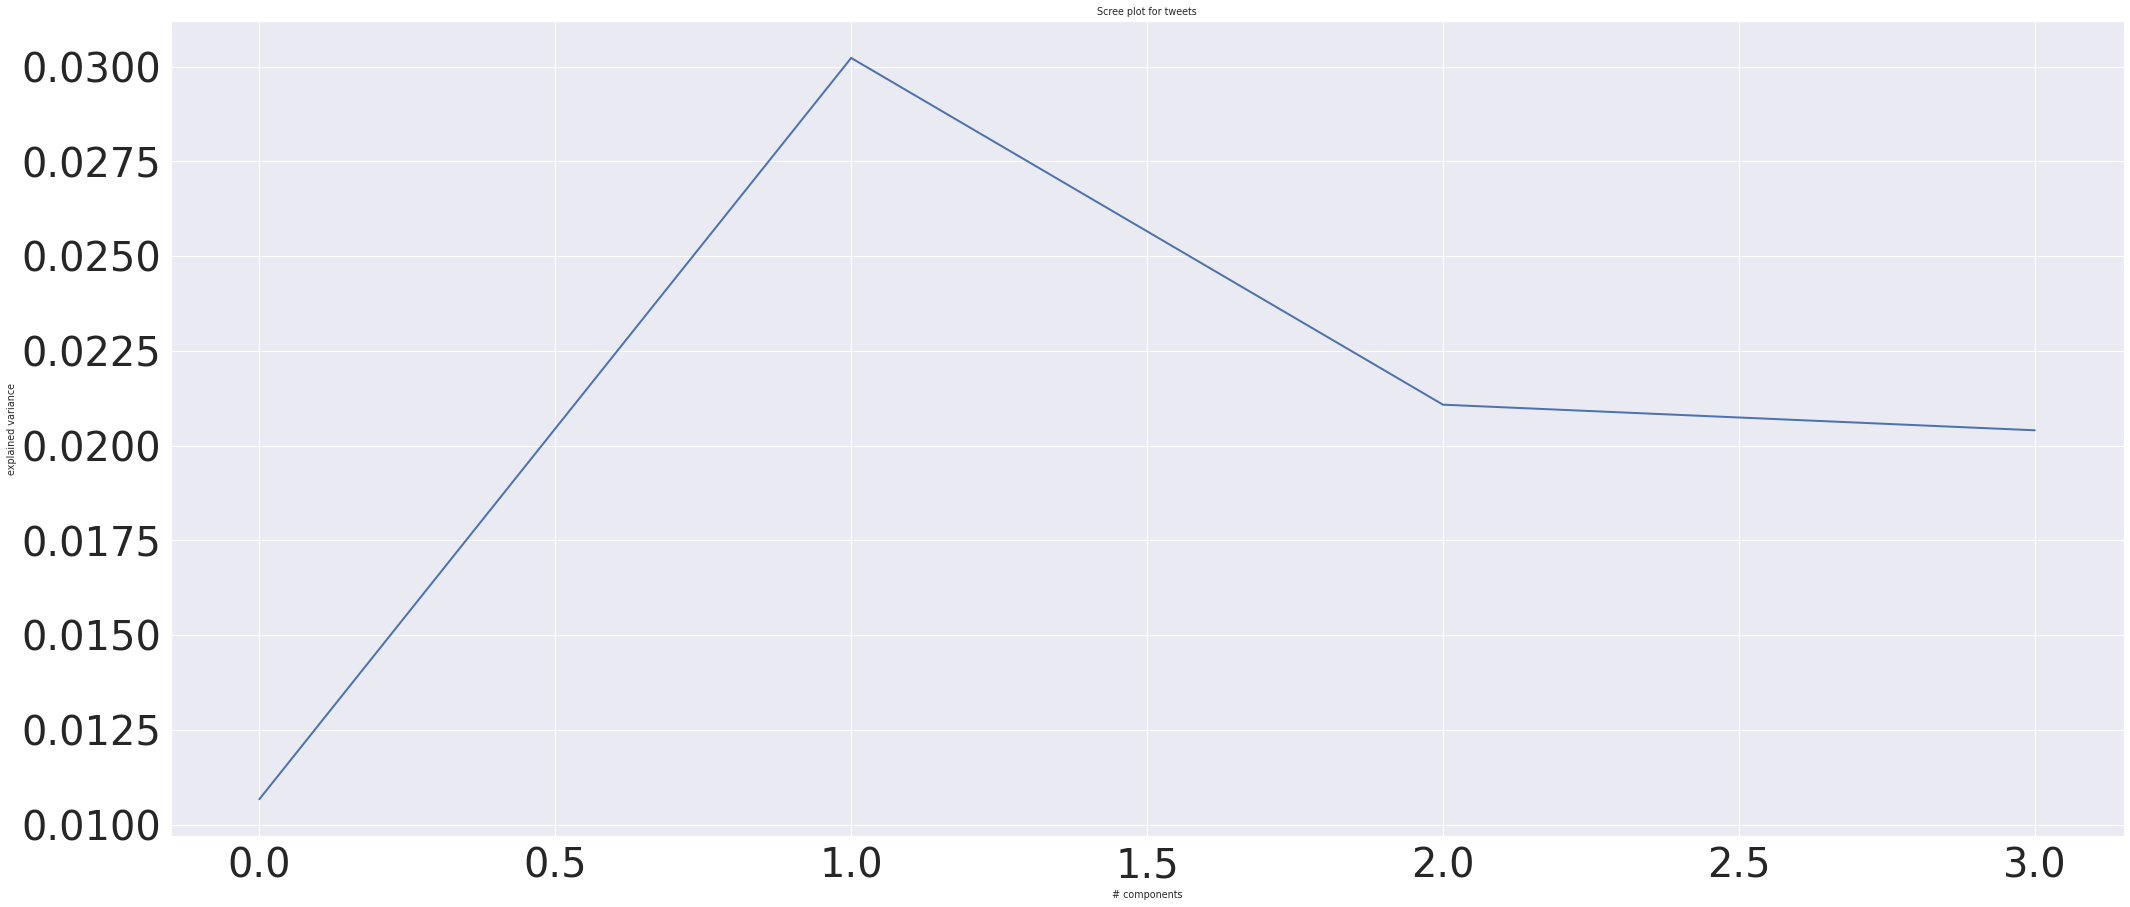

In [ ]:
# we can plot the explained variance to see the optimum number of topics 
plt.plot(lsa.explained_variance_ratio_)
plt.xlabel('# components')
plt.ylabel('explained variance')
plt.title('Scree plot')
plt.tick_params(labelsize=40); # results are unusual for a scree plot, with more time I would definitely investigate this further 

In [ ]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2","component_3", "component_4"],
             columns = word_vectorizer.get_feature_names())
topic_word

,FIRMAS,Lee,Patricia,Wynne,_dokumente,_materialien,abandon,abandoned,abandoning,abc,abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyz,abdin,abe,abide,ability,able,abnormally,abolished,abolition,abominable,about,above,abridged,abroad,abruptly,absence,absent,absolute,absolutely,absolutist,absolutization,absolved,absorbing,abstruse,absurd,absurdity,abu,abuladze,abundance,abuses,...,zakharova,zastrow,zeal,zealand,zealots,zeitung,zelenskii,zelensky,zeman,zen,zero,zeroed,zhao,zhejiang,zhemchugov,zheng,zhijiang,zhirinovsky,zhong,zhuravlev,ziomedia,zionist,zlipixuxp,znaj,znewyork,zodiac,zombies,zomo,zone,zones,zoryan,zoryana,zuan,zuckerberg,zverev,zvezda,łukaszewicz,фото,ххl,الوحيد
component_1,0.003,0.003,0.003,0.003,0.001,0.001,0.010,0.003,0.001,0.001,0.000,0.001,0.001,0.001,0.011,0.026,0.001,0.001,0.002,0.001,0.072,0.019,0.001,0.013,0.001,0.010,0.002,0.008,0.009,0.001,0.002,0.001,0.002,0.002,0.005,0.001,0.001,0.002,0.002,0.001,...,0.003,0.002,0.001,0.002,0.001,0.004,0.003,0.003,0.001,0.004,0.009,0.001,0.004,0.001,0.002,0.001,0.002,0.010,0.001,0.004,0.001,0.006,0.003,0.002,0.001,0.002,0.001,0.001,0.009,0.003,0.001,0.001,0.001,0.001,0.002,0.002,0.001,0.001,0.001,0.001
component_2,-0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.023,-0.003,-0.001,-0.000,-0.001,-0.001,-0.001,-0.000,-0.007,0.001,-0.000,-0.001,-0.001,-0.001,-0.017,0.042,-0.000,-0.012,-0.001,-0.010,-0.002,-0.005,-0.005,-0.000,-0.001,-0.001,-0.001,-0.001,-0.002,-0.001,-0.000,-0.002,-0.001,-0.000,...,-0.003,-0.001,-0.001,-0.001,-0.000,-0.006,-0.000,-0.002,-0.001,-0.004,-0.005,-0.000,-0.003,-0.001,-0.002,-0.002,-0.001,-0.012,-0.000,-0.003,-0.000,0.032,-0.000,-0.003,-0.000,-0.002,-0.000,-0.001,-0.009,-0.002,-0.001,-0.001,-0.001,0.001,-0.002,-0.002,-0.001,0.001,-0.001,-0.000
component_3,-0.004,-0.004,-0.004,-0.004,-0.001,-0.001,-0.013,-0.001,0.002,-0.000,0.000,-0.000,0.001,0.001,-0.023,0.005,0.000,0.000,-0.000,0.000,0.010,-0.004,-0.000,0.043,-0.000,0.013,0.000,-0.010,-0.003,-0.001,-0.004,-0.000,-0.014,-0.001,-0.002,0.000,0.001,-0.000,-0.001,0.001,...,0.001,0.001,-0.001,0.000,-0.001,0.042,-0.002,-0.001,-0.000,-0.001,-0.001,-0.001,-0.001,-0.000,0.000,0.000,-0.000,-0.001,-0.000,-0.001,-0.001,0.003,-0.004,0.000,0.000,-0.000,0.000,0.000,0.036,-0.015,-0.001,-0.001,0.001,-0.000,-0.001,-0.001,0.001,-0.000,-0.000,0.001
component_4,0.004,0.004,0.004,0.004,0.001,0.001,0.012,-0.000,0.001,-0.001,-0.001,-0.001,0.002,0.001,0.017,0.014,-0.001,-0.000,0.001,-0.001,-0.016,-0.001,-0.003,0.007,-0.001,0.045,0.000,0.008,-0.003,0.000,0.006,0.000,0.016,-0.004,-0.004,-0.001,-0.002,-0.002,0.001,0.001,...,-0.005,-0.004,-0.000,-0.001,0.000,0.026,0.002,-0.000,-0.000,-0.005,-0.005,0.001,-0.010,-0.000,-0.005,-0.002,-0.001,-0.027,-0.001,-0.006,0.001,-0.001,0.004,-0.003,-0.000,-0.002,-0.001,0.000,0.023,0.018,-0.001,-0.001,-0.000,-0.001,-0.006,-0.004,-0.001,-0.001,-0.000,-0.000


In [ ]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 0:-1]]))

In [ ]:
display_topics(lsa, word_vectorizer.get_feature_names(), 10) 
# results clearly show our removal of stop words has not worked, with more time this needs to be investigated



Topic  0
the, and, that, are, for, not, coronavirus, with, this

Topic  1
digital, vaccination, gavi, identity, medication, wef, geneva, below, nobody

Topic  2
house, contestants, trudeau, housemates, developments, brother, entry, news, canadian

Topic  3
liberalism, bubbles, gods, financial, modern, societies, civilization, plague, crisis


Second model - NMF (Non-negative Matrix Factorization)

In [ ]:
# NMF on count vectorized data 
nmf_model = NMF(4)
doc_topic = nmf_model.fit_transform(count_vecs)

In [ ]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3", "component_4"],
             columns = cv.get_feature_names())
topic_word

,_dokumente,_materialien,abandon,abandoned,abandoning,abc,abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyz,abdin,abe,abide,ability,able,abnormally,abolished,abolition,abominable,abridged,abroad,abruptly,absence,absent,absolute,absolutely,absolutist,absolutization,absolved,absorbing,abstruse,absurd,absurdity,abu,abuladze,abundance,abuses,abyss,academia,academic,academician,academy,accelerate,...,zen,zero,zeroed,zhao,zhejiang,zhemchugov,zheng,zhijiang,zhirinovsky,zhong,zhuravlev,ziomedia,zionist,zlipixuxp,znaj,znewyork,zodiac,zombies,zomo,zone,zones,zoryan,zoryana,zuan,zuckerberg,zverev,zvezda,łukaszewicz,štětina,štětiny,фото,ххl,الوحيد,عنصر,لاج,𝗙𝗜𝗥𝗠𝗔𝗦,𝗟𝗲𝗲,𝗣𝗮𝘁𝗿𝗶𝗰𝗶𝗮,𝗪𝘆𝗻𝗻𝗲,𝗽𝗼𝗿
component_1,0.000,0.000,0.000,0.000,0.0,0.032,0.000,0.00,0.000,0.000,0.048,0.134,0.000,0.000,0.000,0.009,0.02,0.075,0.00,0.000,0.000,0.000,0.024,0.000,0.000,0.000,0.00,0.009,0.028,0.000,0.001,0.014,0.000,0.000,0.000,0.000,0.013,0.033,0.170,0.011,...,0.019,0.028,0.000,0.031,0.012,0.001,0.003,0.025,0.038,0.032,0.027,0.000,0.000,0.000,0.000,0.000,0.000,0.014,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.025,0.013,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.001,0.000,0.000,0.000,0.000,0.000
component_2,0.000,0.000,0.181,0.000,0.0,0.000,0.000,0.00,0.000,0.000,0.000,0.169,0.000,0.000,0.000,0.000,0.00,0.000,0.00,0.000,0.000,0.003,0.008,0.001,0.000,0.001,0.00,0.000,0.006,0.000,0.000,0.000,0.001,0.000,0.000,0.183,0.000,0.000,0.000,0.000,...,0.000,0.010,0.003,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.183,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_3,0.002,0.002,0.035,0.000,0.0,0.000,0.000,0.00,0.002,0.001,0.138,0.434,0.000,0.000,0.005,0.001,0.00,0.000,0.00,0.085,0.002,0.108,0.010,0.001,0.069,0.001,0.03,0.000,0.000,0.000,0.000,0.001,0.006,0.001,0.048,0.000,0.028,0.000,0.000,0.000,...,0.000,0.005,0.021,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.002,0.000,0.029,0.000,0.000,0.000,0.000,0.000,0.000,0.075,0.000,0.000,0.000,0.005,0.000,0.000,0.000,0.000,0.000,0.005,0.000,0.001,0.001,0.001,0.029,0.029,0.029,0.029,0.029
component_4,0.004,0.004,0.000,0.019,0.0,0.000,0.001,0.01,0.015,0.007,0.018,0.147,0.013,0.001,0.027,0.000,0.00,0.127,0.01,0.096,0.020,0.007,0.069,0.002,0.000,0.002,0.00,0.000,0.022,0.007,0.001,0.003,0.010,0.007,0.000,0.000,0.013,0.012,0.003,0.008,...,0.004,0.067,0.000,0.001,0.004,0.002,0.000,0.008,0.016,0.000,0.030,0.004,0.000,0.016,0.001,0.015,0.039,0.003,0.006,0.131,0.000,0.005,0.005,0.004,0.002,0.006,0.015,0.003,0.028,0.004,0.002,0.003,0.003,0.003,0.003,0.016,0.016,0.016,0.016,0.016


In [ ]:
display_topics(nmf_model, cv.get_feature_names(), 15)



Topic  0
china, chinese, virus, biological, coronavirus, united, states, american, weapons, wuhan, people, new, world, epidemic

Topic  1
world, china, italy, people, coronavirus, digital, death, war, pandemic, vaccination, virus, rate, years, control

Topic  2
world, states, coronavirus, state, global, united, epidemic, economic, new, countries, globalization, order, pandemic, crisis

Topic  3
coronavirus, people, said, march, new, cases, crisis, covid, country, european, president, social, russia, spread


In [ ]:
# NMF on TF-IDF data
nmf_model = NMF(5)
nmf_topics = nmf_model.fit_transform(tfidf_vecs)

In [ ]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3", "component_4", "component_5"],
             columns = word_vectorizer.get_feature_names())
topic_word

,FIRMAS,Lee,Patricia,Wynne,_dokumente,_materialien,abandon,abandoned,abandoning,abc,abcdefghijklmnopqrstuvwxyzabcdefghijklmnopqrstuvwxyz,abdin,abe,abide,ability,able,abnormally,abolished,abolition,abominable,about,above,abridged,abroad,abruptly,absence,absent,absolute,absolutely,absolutist,absolutization,absolved,absorbing,abstruse,absurd,absurdity,abu,abuladze,abundance,abuses,...,zakharova,zastrow,zeal,zealand,zealots,zeitung,zelenskii,zelensky,zeman,zen,zero,zeroed,zhao,zhejiang,zhemchugov,zheng,zhijiang,zhirinovsky,zhong,zhuravlev,ziomedia,zionist,zlipixuxp,znaj,znewyork,zodiac,zombies,zomo,zone,zones,zoryan,zoryana,zuan,zuckerberg,zverev,zvezda,łukaszewicz,фото,ххl,الوحيد
component_1,0.006,0.006,0.006,0.006,0.002,0.002,0.003,0.009,0.003,0.003,0.002,0.002,0.002,0.001,0.016,0.043,0.002,0.002,0.003,0.003,0.150,0.018,0.003,0.015,0.003,0.000,0.006,0.017,0.025,0.002,0.001,0.003,0.000,0.005,0.014,0.003,0.003,0.007,0.004,0.001,...,0.010,0.006,0.003,0.005,0.002,0.000,0.005,0.009,0.003,0.013,0.024,0.002,0.012,0.003,0.005,0.004,0.004,0.033,0.003,0.011,0.002,0.000,0.006,0.006,0.002,0.006,0.003,0.003,0.007,0.000,0.004,0.004,0.003,0.002,0.007,0.007,0.003,0.002,0.003,0.002
component_2,0.001,0.001,0.001,0.001,0.001,0.001,0.038,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.025,0.000,0.000,0.000,0.000,0.045,0.068,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.001,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,...,0.000,0.001,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.044,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.002,0.000,0.000
component_3,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.002,0.001,0.001,0.033,0.000,0.001,0.001,0.001,0.040,0.000,0.000,0.049,0.000,0.054,0.001,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.001,...,0.000,0.000,0.000,0.001,0.000,0.066,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.001,0.061,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.001,0.000,0.000,0.001
component_4,0.003,0.003,0.003,0.003,0.001,0.001,0.027,0.001,0.000,0.000,0.000,0.000,0.001,0.001,0.048,0.032,0.000,0.000,0.002,0.000,0.036,0.016,0.000,0.000,0.000,0.048,0.000,0.019,0.002,0.001,0.010,0.000,0.032,0.000,0.000,0.000,0.000,0.000,0.002,0.001,...,0.000,0.000,0.001,0.000,0.001,0.000,0.003,0.001,0.001,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.003,0.000,0.000,0.000,0.000,0.000,0.000,0.035,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_5,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.099,0.000,0.000,0.111,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,...,0.001,0.000,0.000,0.002,0.000,0.000,0.001,0.000,0.001,0.002,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.001,0.000,0.001


In [ ]:
# view top 15 words per topic 
display_topics(nmf_model, word_vectorizer.get_feature_names(), 15)



Topic  0
the, and, that, are, coronavirus, with, this, not, for, was, from, china, will, virus

Topic  1
digital, vaccination, identity, gavi, medication, wef, nobody, alliance, geneva, partners, below, kissinger, reduction, bangladesh

Topic  2
housemates, trudeau, contestants, developments, brother, house, entry, canadian, crisis, ban, entered, exploit, evictions, producers

Topic  3
liberalism, bubbles, gods, plague, modern, civilization, societies, collapse, vacuum, globalization, bubble, criteria, nothing, nor

Topic  4
advertisers, cop, programs, channel, movies, fifth, shows, news, truth, day, reception, fatherland, nuances, rss


I will now use LDA (Latent Dirilecht Allocation)

In [ ]:
# LDA on count vectorized 

# create the term-doc matrix, transpose so that terms are rows
doc_word = cv.transform(count_vecs).transpose()
print(doc_word.shape)
pd.DataFrame(doc_word.toarray(), cv.get_feature_names()).head()


(10385, 10385)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,10345,10346,10347,10348,10349,10350,10351,10352,10353,10354,10355,10356,10357,10358,10359,10360,10361,10362,10363,10364,10365,10366,10367,10368,10369,10370,10371,10372,10373,10374,10375,10376,10377,10378,10379,10380,10381,10382,10383,10384
_dokumente,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
_materialien,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abandon,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abandoned,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
abandoning,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# convert sparse matrix of counts to a gensim corpus 
corpus = matutils.Sparse2Corpus(doc_word)

In [ ]:
id2word = dict((v, k) for k, v in cv.vocabulary_.items())

# check that length matches corpus
len(id2word)


10385

In [ ]:
# fit the model
lda = models.LdaModel(corpus=corpus, num_topics=3, id2word=id2word, passes=5)

In [ ]:
lda.print_topics()

[(0,
  '0.000*"ratified" + 0.000*"provocation" + 0.000*"resolving" + 0.000*"poisoned" + 0.000*"proposed" + 0.000*"pack" + 0.000*"planned" + 0.000*"newest" + 0.000*"relieve" + 0.000*"number"'),
 (1,
  '0.001*"worsened" + 0.001*"الوحيد" + 0.001*"waves" + 0.001*"weird" + 0.001*"widespread" + 0.001*"wrath" + 0.001*"württemberg" + 0.001*"zhuravlev" + 0.001*"weigh" + 0.001*"wreaking"'),
 (2,
  '0.000*"shouts" + 0.000*"tree" + 0.000*"superstrings" + 0.000*"unbelievable" + 0.000*"textiles" + 0.000*"shipment" + 0.000*"suspect" + 0.000*"senators" + 0.000*"store" + 0.000*"smile"')]

I will now try a PCA model

In [ ]:
# PCA on TF-IDF
pca = PCA(n_components=10) 
pca.fit(tfidf_vecs)
pcafeatures_train = pca.transform(tfidf_vecs)

In [ ]:
pca.explained_variance_ratio_


array([0.03440167, 0.02207383, 0.02108284, 0.01946928, 0.01641032,
       0.01594737, 0.01367999, 0.01253458, 0.0117946 , 0.01158017])

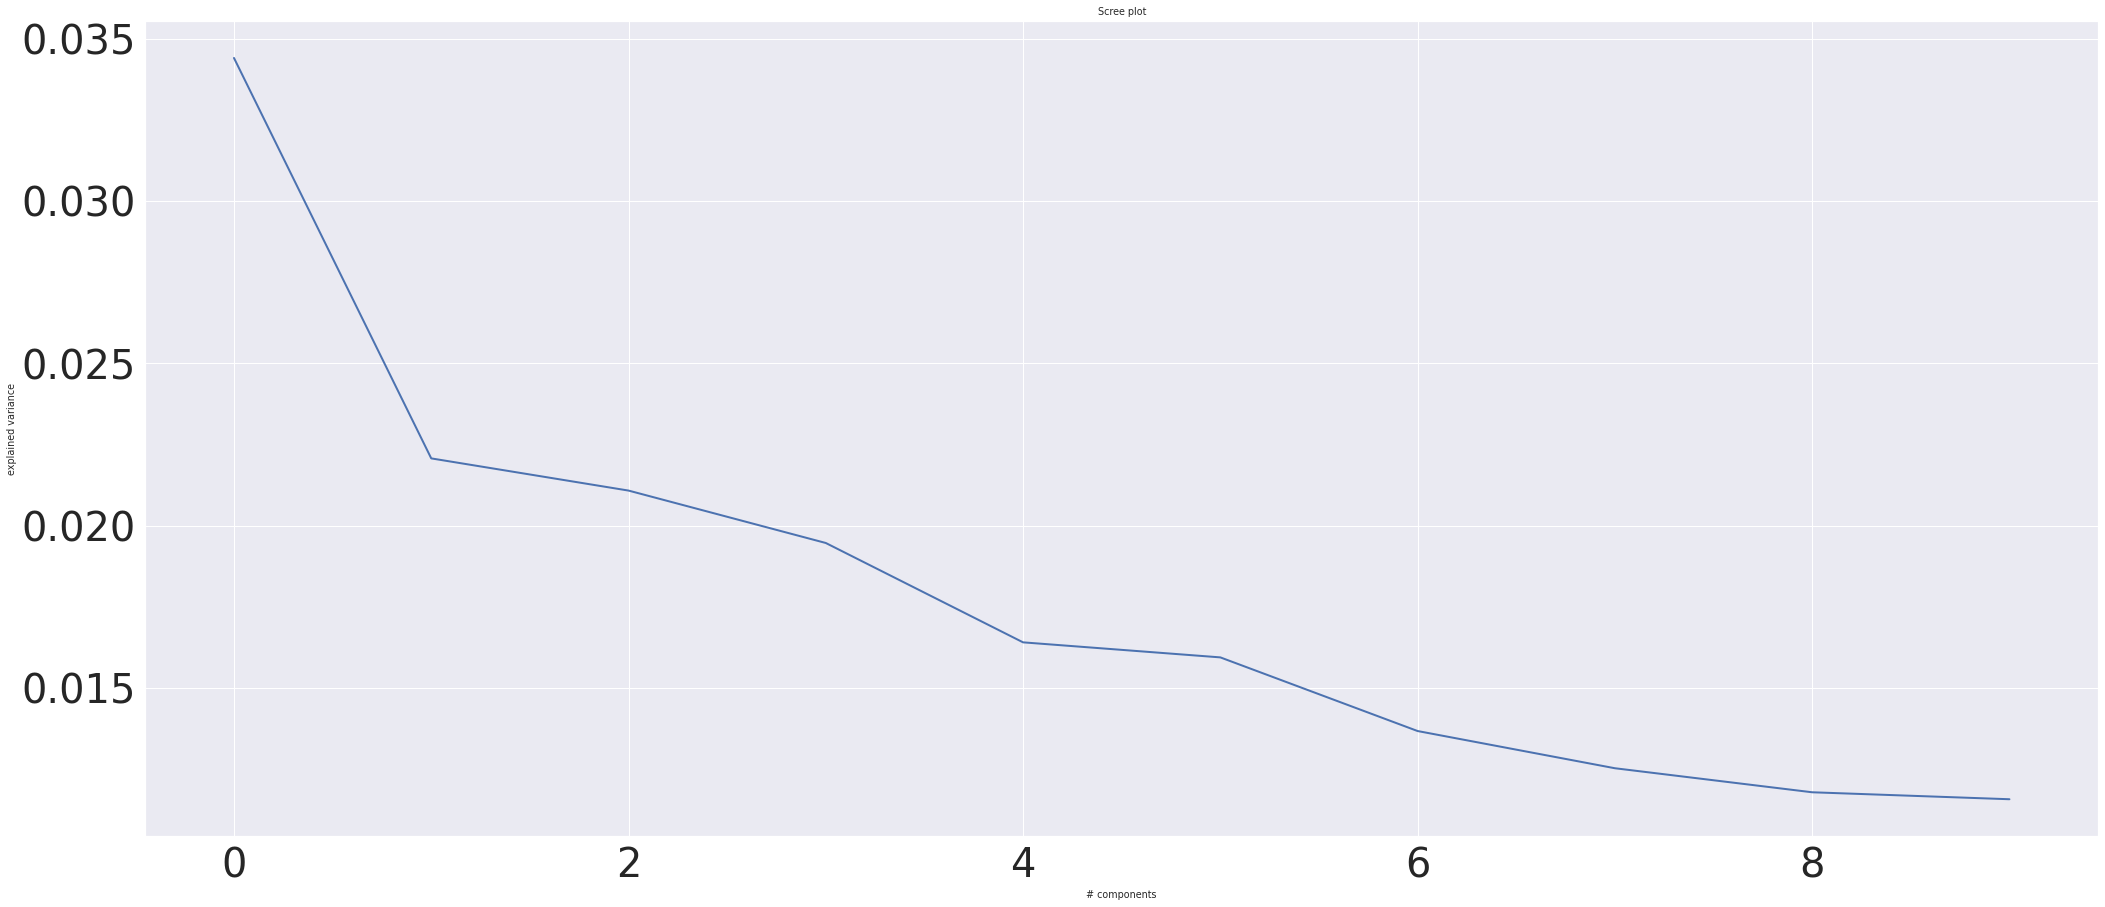

In [ ]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('# components')
plt.ylabel('explained variance')
plt.title('Scree plot')
plt.tick_params(labelsize=40);

So far, I have been reviewing the topics by reading the words in each one and playing around with the numbers based on my domain knowledge. However there is a more mathematical way to do this, and we can visualise the separation between topics using a t-SNE plot

In [ ]:
import time
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123

In [ ]:
# function to visualize the outputs of PCA and t-SNE

def scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

In [ ]:
tsne = TSNE(random_state=RS).fit_transform(nmf_topics)
# scatter(tsne, text_data.text) # this has not worked and needs to be investigated further 